# First steps:
- create datajoint config file
- enter credentials in the config file (dj_local_conf.json)
- if you want to access the raw tiff files, you have to specify the location of the movies, where you put the Data folder
- place config file in the working directory
# the config file (dj_local_conf.json) :
{<br>
  "connection.init_function": null,<br>
  "database.host": "mesoscale-activity.datajoint.io",<br>
  "database.password": "-------------------------------------password-comes-here--",<br>
  "database.port": 3306,<br>
  "database.reconnect": false,<br>
  "database.user": "-----------------------------------------username comes here --",<br>
  "display.limit": 7,<br>
  "display.show_tuple_count": true,<br>
  "display.width": 14,<br>
  "do_unittest": true,<br>
  "enable_python_native_blobs": true,<br>
  "external.aws_access_key_id": null,<br>
  "external.aws_secret_access_key": null,<br>
  "external.location": null,<br>
  "history": [],<br>
  "locations.mr_share": "------------------------------------location of the Data folder files comes here - if you want to access the raw movies",<br>
  "loglevel": "INFO",<br>
  "project": "voltage imaging",<br>
  "safemode": true<br>
}

In [1]:
# make sure that the working directory is the root directory of this repo
%cd '/home/rozmar/Scripts/Python/DataPipeline/'
import datajoint as dj
dj.conn() # if you are requested to give a username then you forgot to add the config file
from pipeline import pipeline_tools
from pipeline import lab, experiment, ephys_patch, ephysanal, imaging, imaging_gt
from plot import plot_imaging
from voltageimaging import voltage_imaging_utils
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import rc
font = {'size'   : 16}
rc('font', **font)
dj.config['locations.mr_share'] # this should give the location of the local repository, in my case, the Data folder is in /home/rozmar/

/home/rozmar/Scripts/Python/DataPipeline
Connecting rozmar@mesoscale-activity.datajoint.io:3306


'/home/rozmar/'

the metadata and file locations to all movies are in the imaging.Movie table

In [2]:
imaging.Movie()

subject_id institution 6 digit animal ID,session session number,movie_number,movie_name movie name,movie_x_size (pixels),movie_y_size (pixels),movie_frame_rate (Hz),movie_frame_num number of frames,movie_start_time (s) from session start # maybe end_time would also be useful,movie_pixel_size in microns
454597,1,0,40x_patch1,512.0,128.0,401.6064257028113,80000,254.386695,0.59
456462,1,0,40x_1xtube_10A2,512.0,128.0,401.6064257028113,100000,6351.083750,0.59
456462,1,1,40x_1xtube_10A3,512.0,128.0,401.6064257028113,100000,6785.686132,0.59
456462,1,2,40x_1xtube_10A4,512.0,128.0,401.6064257028113,100000,8098.122991,0.59
456462,1,3,40x_1xtube_10A5,512.0,128.0,401.60642570281124,50000,9922.298630,0.59
456462,1,4,40x_1xtube_10A6,512.0,128.0,401.60642570281124,50000,10118.098150,0.59
456462,1,5,40x_1xtube_10A7,512.0,128.0,401.60642570281124,50000,10358.610739,0.59


In [3]:
### First select a movie either by iterating over the movies or defining it as a dictionary.
movie_key = {'subject_id': 456462,
             'session' : 1, 
             'movie_number' : 0} 
### Selecting a single movie from the above table with the defined dictionary:
imaging.Movie()&movie_key

subject_id institution 6 digit animal ID,session session number,movie_number,movie_name movie name,movie_x_size (pixels),movie_y_size (pixels),movie_frame_rate (Hz),movie_frame_num number of frames,movie_start_time (s) from session start # maybe end_time would also be useful,movie_pixel_size in microns
456462,1,0,40x_1xtube_10A2,512.0,128.0,401.6064257028113,100000,6351.083750,0.59


In [4]:
### The location and name of the tiff files can be accessed via the imaging.MovieFile() table. <br>
movie_files = list()
repositories , directories , fnames = (imaging.MovieFile() & movie_key).fetch('movie_file_repository','movie_file_directory','movie_file_name')
for repository,directory,fname in zip(repositories,directories,fnames):
    movie_files.append(os.path.join(dj.config['locations.{}'.format(repository)],directory,fname))
movie_files[0:3]


['/home/rozmar/Data/Voltage_imaging/raw/Voltage_rig_1P/rozsam/20191220/40x_1xtube_10A2/40x_1xtube_10A2_000.tif',
 '/home/rozmar/Data/Voltage_imaging/raw/Voltage_rig_1P/rozsam/20191220/40x_1xtube_10A2/40x_1xtube_10A2_001.tif',
 '/home/rozmar/Data/Voltage_imaging/raw/Voltage_rig_1P/rozsam/20191220/40x_1xtube_10A2/40x_1xtube_10A2_002.tif']

In [5]:
# the frame times can be accessed in the imaging.MovieFrameTimes() table
# it's relative to the start of the session start
frametimes = (imaging.MovieFrameTimes()&movie_key).fetch1('frame_times')
session_start_time = ((experiment.Session()&movie_key).fetch1('session_time')).total_seconds()
frametimes = frametimes + session_start_time
frametimes # frametimes from midnight, in seconds

array([76236.08375 , 76236.086245, 76236.08874 , ..., 76485.523056,
       76485.525551, 76485.528046])

In [6]:
# we have extracted the ophys with multiple methods so you have to specify which methods you are interested in
rois_key = movie_key.copy() # you need the movie key and extend it wit more information
rois_key['roi_type'] = 'SpikePursuit' # Spikepursuit, VolPy  (currently, they are very similar)
rois_key['motion_correction_method'] = 'Matlab' # Matlab, for Spikepursuit ROIs, VolPy for VolPy ROIs  (currently)
imaging.ROI()&rois_key # there are 4 ROIs extracted in this movie

subject_id institution 6 digit animal ID,session session number,movie_number,motion_correction_method,roi_type,roi_number roi number (restarts for every registered movie),roi_dff spikepursuit,roi_f0 spikepursuit,roi_spike_indices spikepursuit,"roi_centroid_x ROI centroid x, pixels","roi_centroid_y ROI centroid y, pixels",roi_mask pixel mask
456462,1,0,Matlab,SpikePursuit,1,=BLOB=,=BLOB=,=BLOB=,273.5,92.5,=BLOB=
456462,1,0,Matlab,SpikePursuit,2,=BLOB=,=BLOB=,=BLOB=,207.0,36.5,=BLOB=
456462,1,0,Matlab,SpikePursuit,3,=BLOB=,=BLOB=,=BLOB=,143.5,48.5,=BLOB=
456462,1,0,Matlab,SpikePursuit,4,=BLOB=,=BLOB=,=BLOB=,193.5,88.5,=BLOB=


In [7]:
# if you are interested in the patched cell, you use the grountruthROI table
imaging.ROI()*imaging_gt.GroundTruthROI()&rois_key

subject_id institution 6 digit animal ID,session session number,movie_number,motion_correction_method,roi_type,roi_number roi number (restarts for every registered movie),cell_number,roi_dff spikepursuit,roi_f0 spikepursuit,roi_spike_indices spikepursuit,"roi_centroid_x ROI centroid x, pixels","roi_centroid_y ROI centroid y, pixels",roi_mask pixel mask,"ephys_matched_ap_times in seconds, from the start of the session","ophys_matched_ap_times in seconds, from the start of the session","ephys_unmatched_ap_times in seconds, from the start of the session","ophys_unmatched_ap_times in seconds, from the start of the session"
456462,1,0,Matlab,SpikePursuit,1,3,=BLOB=,=BLOB=,=BLOB=,273.5,92.5,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=


Text(0, 0.5, 'dF/F')

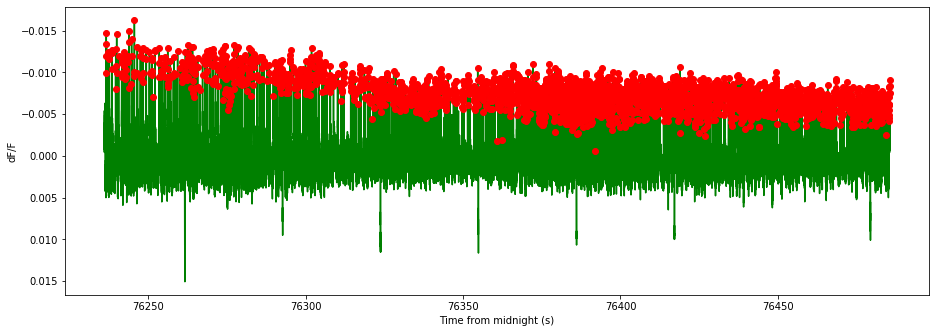

In [8]:
# to extract dff trace from the recorded ROI:
dff,spike_indices = (imaging.ROI()*imaging_gt.GroundTruthROI()&rois_key).fetch1('roi_dff','roi_spike_indices')
fig=plt.figure()
ax_ophys=fig.add_axes([0,0,2,1])
ax_ophys.plot(frametimes,dff,'g-')
ax_ophys.plot(frametimes[spike_indices-1],dff[spike_indices-1],'ro') # these are matlab indices... :S
ax_ophys.invert_yaxis()
ax_ophys.set_xlabel('Time from midnight (s)')
ax_ophys.set_ylabel('dF/F')

In [9]:
# The corresponding ephys recordings are in the imaging_gt.CellMovieCorrespondance table
imaging_gt.CellMovieCorrespondance()

subject_id institution 6 digit animal ID,session session number,cell_number,movie_number,sweep_numbers sweep numbers that
454597,1,0,0,=BLOB=
456462,1,3,0,=BLOB=
456462,1,3,1,=BLOB=
456462,1,4,2,=BLOB=
456462,1,5,3,=BLOB=
456462,1,5,4,=BLOB=
456462,1,5,5,=BLOB=


In [10]:
# for a given movie one has to specify the subject, session, movie number and cell number based on this table
imaging.Movie()*imaging_gt.CellMovieCorrespondance()&movie_key

subject_id institution 6 digit animal ID,session session number,movie_number,cell_number,movie_name movie name,movie_x_size (pixels),movie_y_size (pixels),movie_frame_rate (Hz),movie_frame_num number of frames,movie_start_time (s) from session start # maybe end_time would also be useful,movie_pixel_size in microns,sweep_numbers sweep numbers that
456462,1,0,3,40x_1xtube_10A2,512.0,128.0,401.6064257028113,100000,6351.083750,0.59,=BLOB=


exctracting sweep 28
exctracting sweep 29
exctracting sweep 30
exctracting sweep 31
exctracting sweep 32
exctracting sweep 33
exctracting sweep 34
exctracting sweep 35
exctracting sweep 36


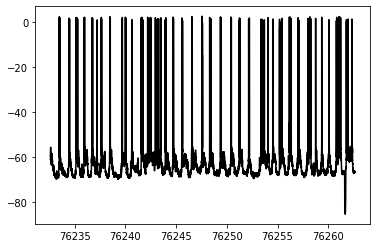

In [11]:
# extract the corresponding sweep numbers
sweep_numbers = (imaging.Movie()*imaging_gt.CellMovieCorrespondance()&movie_key).fetch1('sweep_numbers')
# the ephys time is stored relative to the recording start of the cell
cell_recording_start = ((imaging_gt.CellMovieCorrespondance()*ephys_patch.Cell()&movie_key).fetch1('cell_recording_start')).total_seconds()
# iterate over the sweep numbers to get each sweep
voltage =list()
stimulus = list()
ephys_time = list()
for sweep_number in sweep_numbers:
    print('exctracting sweep {}'.format(sweep_number))
    sweep_key = movie_key.copy()
    sweep_key['sweep_number'] = sweep_number # add sweep number to the key
    voltage_now,stimulus_now,sweep_time_now =  voltage_imaging_utils.get_sweep(sweep_key, downsampled_rate = 10000)
    voltage.append(voltage_now)
    stimulus.append(stimulus_now)
    ephys_time.append(sweep_time_now + cell_recording_start)
plt.plot(ephys_time[0],voltage[0],'-k')

(76236.08375, 76485.528046)

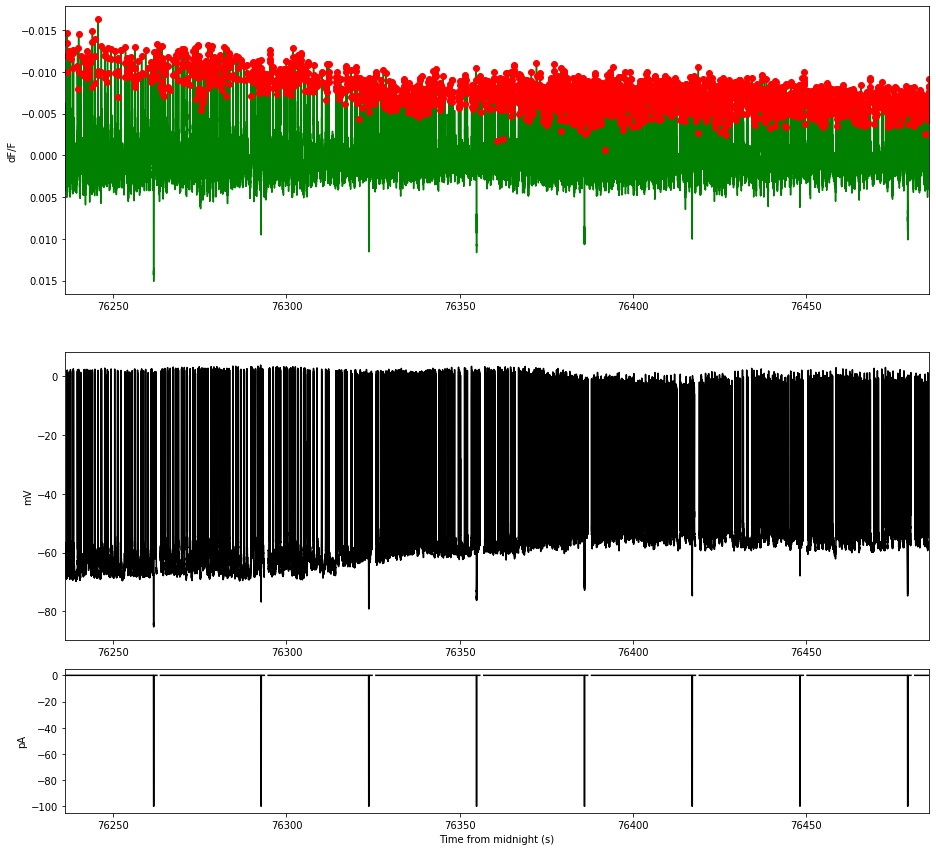

In [12]:
fig=plt.figure()
ax_ophys=fig.add_axes([0,0,2,1])
ax_ophys.plot(frametimes,dff,'g-')
ax_ophys.plot(frametimes[spike_indices-1],dff[spike_indices-1],'ro') # these are matlab indices... :S
ax_ophys.invert_yaxis()
ax_ophys.set_ylabel('dF/F')
ax_ophys.set_xlim([frametimes[0],frametimes[-1]])
ax_ephys=fig.add_axes([0,-1.2,2,1])
ax_ephys_stim=fig.add_axes([0,-1.8,2,.5])
for v,i,t in zip(voltage,stimulus,ephys_time):
    ax_ephys.plot(t,v,'-k')
    ax_ephys_stim.plot(t,i,'-k')
ax_ephys_stim.set_xlabel('Time from midnight (s)')
ax_ephys.set_ylabel('mV')
ax_ephys_stim.set_ylabel('pA')
ax_ephys.set_xlim([frametimes[0],frametimes[-1]])
ax_ephys_stim.set_xlim([frametimes[0],frametimes[-1]])

/home/rozmar/anaconda3/envs/datajoint/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/rozmar/anaconda3/envs/datajoint/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/rozmar/anaconda3/envs/datajoint/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/rozmar/anaconda3/envs/datajoint/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/rozmar/anaconda3/envs/datajoint/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


    session  subject_id  cell_number motion_correction_method  \
0         1      454597            0                   Matlab   
1         1      456462            3                   Matlab   
2         1      456462            4                   Matlab   
3         1      456462            5                   Matlab   
4         1      456462            6                   Matlab   
5         1      456462            8                   Matlab   
6         1      462147            0                   Matlab   
7         1      462147            1                   Matlab   
8         1      462147            2                   Matlab   
9         1      462149            1                   Matlab   
10        1      462149            3                   Matlab   
11        1      462149            4                   Matlab   
12        1      463291            1                   Matlab   
13        1      463291            2                   Matlab   
14        1      466769  

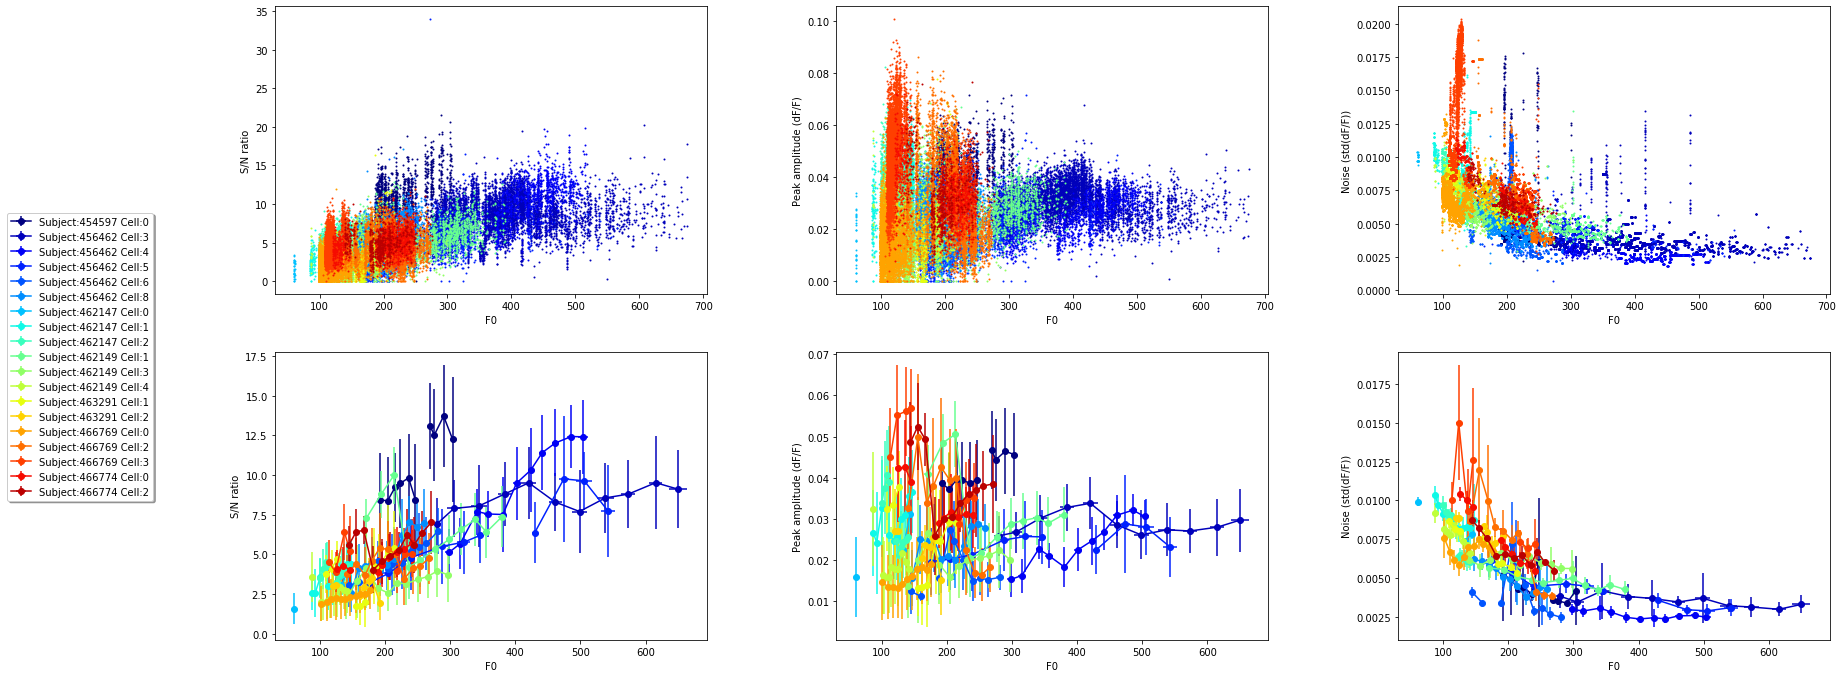

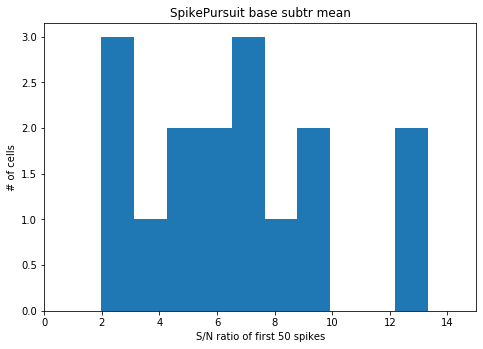

In [13]:
# Plot SNratios for all cells
plot_imaging.plot_cell_SN_ratio_APwise(roi_type = 'SpikePursuit_base_subtr_mean',
                                       v0_max = -35,
                                       holding_min = -600,
                                       frame_rate_min =300, 
                                       frame_rate_max = 1200 ,
                                       bin_num = 10 )      